The self similarity on frames concept
===============================

In [1]:
%load_ext autoreload

In [172]:
%autoreload

from utils.streams import DataStreams
from pipe import *

d = DataStreams()

# use this cautiously, do you have enough RAM?!
d.use_cache = True

In [3]:
import keras
from keras.applications import VGG16

conv_base = VGG16(include_top=False, 
                     weights='imagenet', 
                     input_shape=(d.video_size, d.video_size, 3), 
                     pooling=None)

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

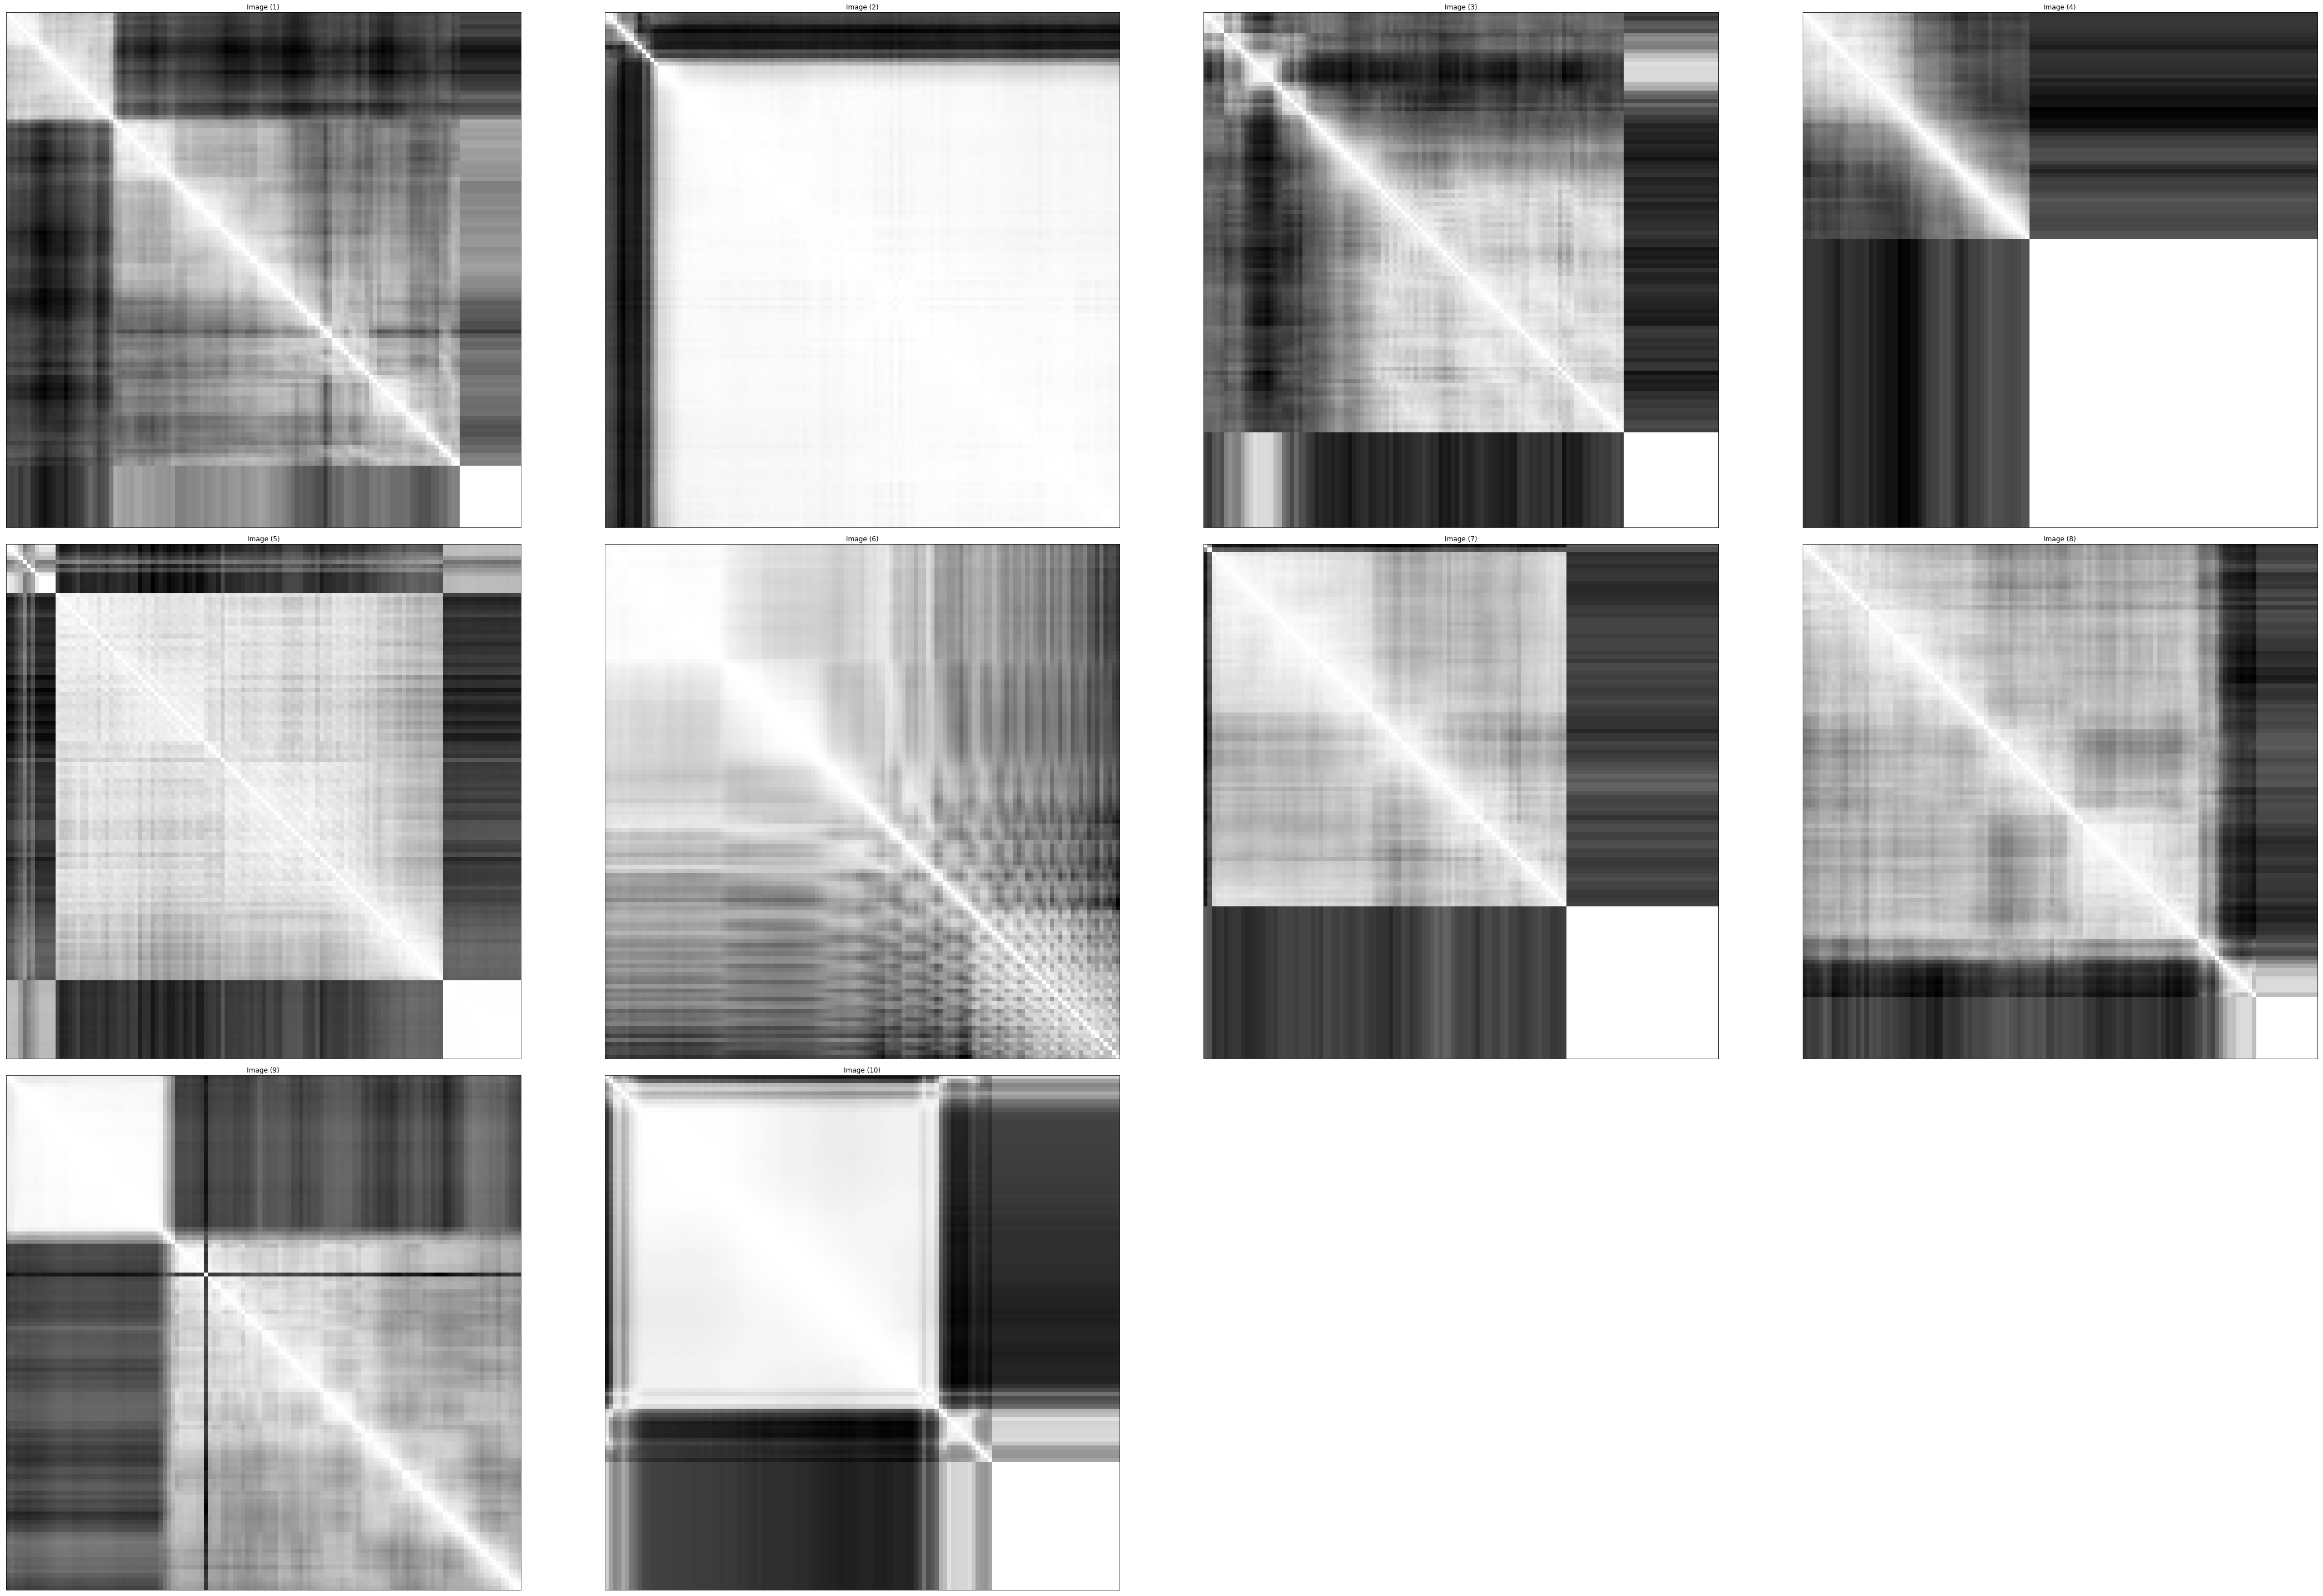

In [308]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils.image import *
from utils.video import *
from utils.pipeutils import *

@Pipe
def get_sim_mat(flow): 
    while True:
        video = next(flow)
        frame_embeds = conv_base.predict( video[2] ).reshape(125,512*2*2)
        frame_embeds =(frame_embeds.transpose() / np.linalg.norm(frame_embeds,axis=1)).transpose()
        frame_embeds.shape

        simmat = np.zeros( (125,125) )
        simmat = np.dot( frame_embeds, frame_embeds.transpose() )
        
        trans = simmat
        
        trans = trans / np.max(np.max(trans))
        
        yield (video[0], trans )

sims_train = d.video_stream_with_zeropad(validation_data=False) | get_sim_mat()
 
show_images(sims_train | take(10) | select(lambda i: i[1]) | as_list(), cols=3)

In [281]:
@Pipe
def batch_flow(flow, batchsize=10):
    while (True):
        batch = np.zeros((batchsize, 125, 125,1))
        labels = np.zeros((batchsize, 1))
        for i in range(batchsize):
            video = next(flow)
            batch[i] = video[1].reshape(125,125,1)
            labels[i] = video[0]
        yield (batch, labels)

In [304]:
# from keras import layers
from keras import models, layers
from keras import regularizers

model = models.Sequential()
model.add(layers.MaxPooling2D((3, 3), input_shape=(125,125, 1)))
model.add(layers.Conv2D(32,(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(64,(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(64,(3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_18 (MaxPooling (None, 41, 41, 1)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 39, 39, 32)        320       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten_8 (Flatten)          (None, 64)                0         
__________

In [307]:
from keras import optimizers
from keras import callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Nadam(lr=0.002),
              metrics=['acc'])

filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

checkpoint =  callbacks.ModelCheckpoint(filepath, 
                          monitor='val_loss', 
                          verbose=0, 
                          save_best_only=False, 
                          save_weights_only=False, 
                          mode='auto', 
                          period=1)

sims_train_batch = d.video_stream_with_zeropad(validation_data=False) | get_sim_mat() | batch_flow()
sims_val_batch = d.video_stream_with_zeropad(validation_data=True) | get_sim_mat() | batch_flow()

history = model.fit_generator(
      sims_train_batch,
      steps_per_epoch=20, 
      validation_data=sims_val_batch, 
      # has to be false on windows..
      use_multiprocessing=False, 
      validation_steps = 15,
      epochs=10,
      callbacks = [checkpoint])

Epoch 1/10
20/20 [==============================] - 20s 1s/step - loss: 0.7014 - acc: 0.5050 - val_loss: 0.6934 - val_acc: 0.4533
Epoch 2/10
20/20 [==============================] - 15s 742ms/step - loss: 0.6943 - acc: 0.4650 - val_loss: 0.6936 - val_acc: 0.4400
Epoch 3/10
20/20 [==============================] - 15s 747ms/step - loss: 0.6986 - acc: 0.4800 - val_loss: 0.6929 - val_acc: 0.5067
Epoch 4/10
20/20 [==============================] - 15s 747ms/step - loss: 0.6941 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.4933
Epoch 5/10
20/20 [==============================] - 15s 751ms/step - loss: 0.6935 - acc: 0.4450 - val_loss: 0.6933 - val_acc: 0.4667
Epoch 6/10
14/20 [====================>.........] - ETA: 3s - loss: 0.6935 - acc: 0.4571

KeyboardInterrupt: 

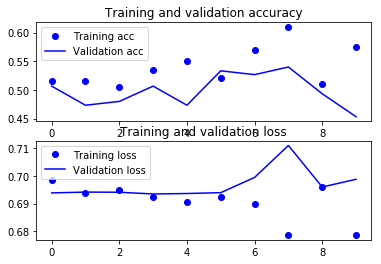

In [299]:
%autoreload

from utils.plotutils import plot_model

plot_model(history)

This is not so good, maybe CNN not the right way. let's try and see with visual inspection what is going on. 

In [80]:
mats_col = d.video_stream_with_zeropad(validation_data=False) | where( lambda f: f[0]==1 ) | get_sim_mat() | take(150) | as_list()
mats_ncol = d.video_stream_with_zeropad(validation_data=False) | where( lambda f: f[0]==0 ) | get_sim_mat() | take(150) | as_list()


NOT collisions

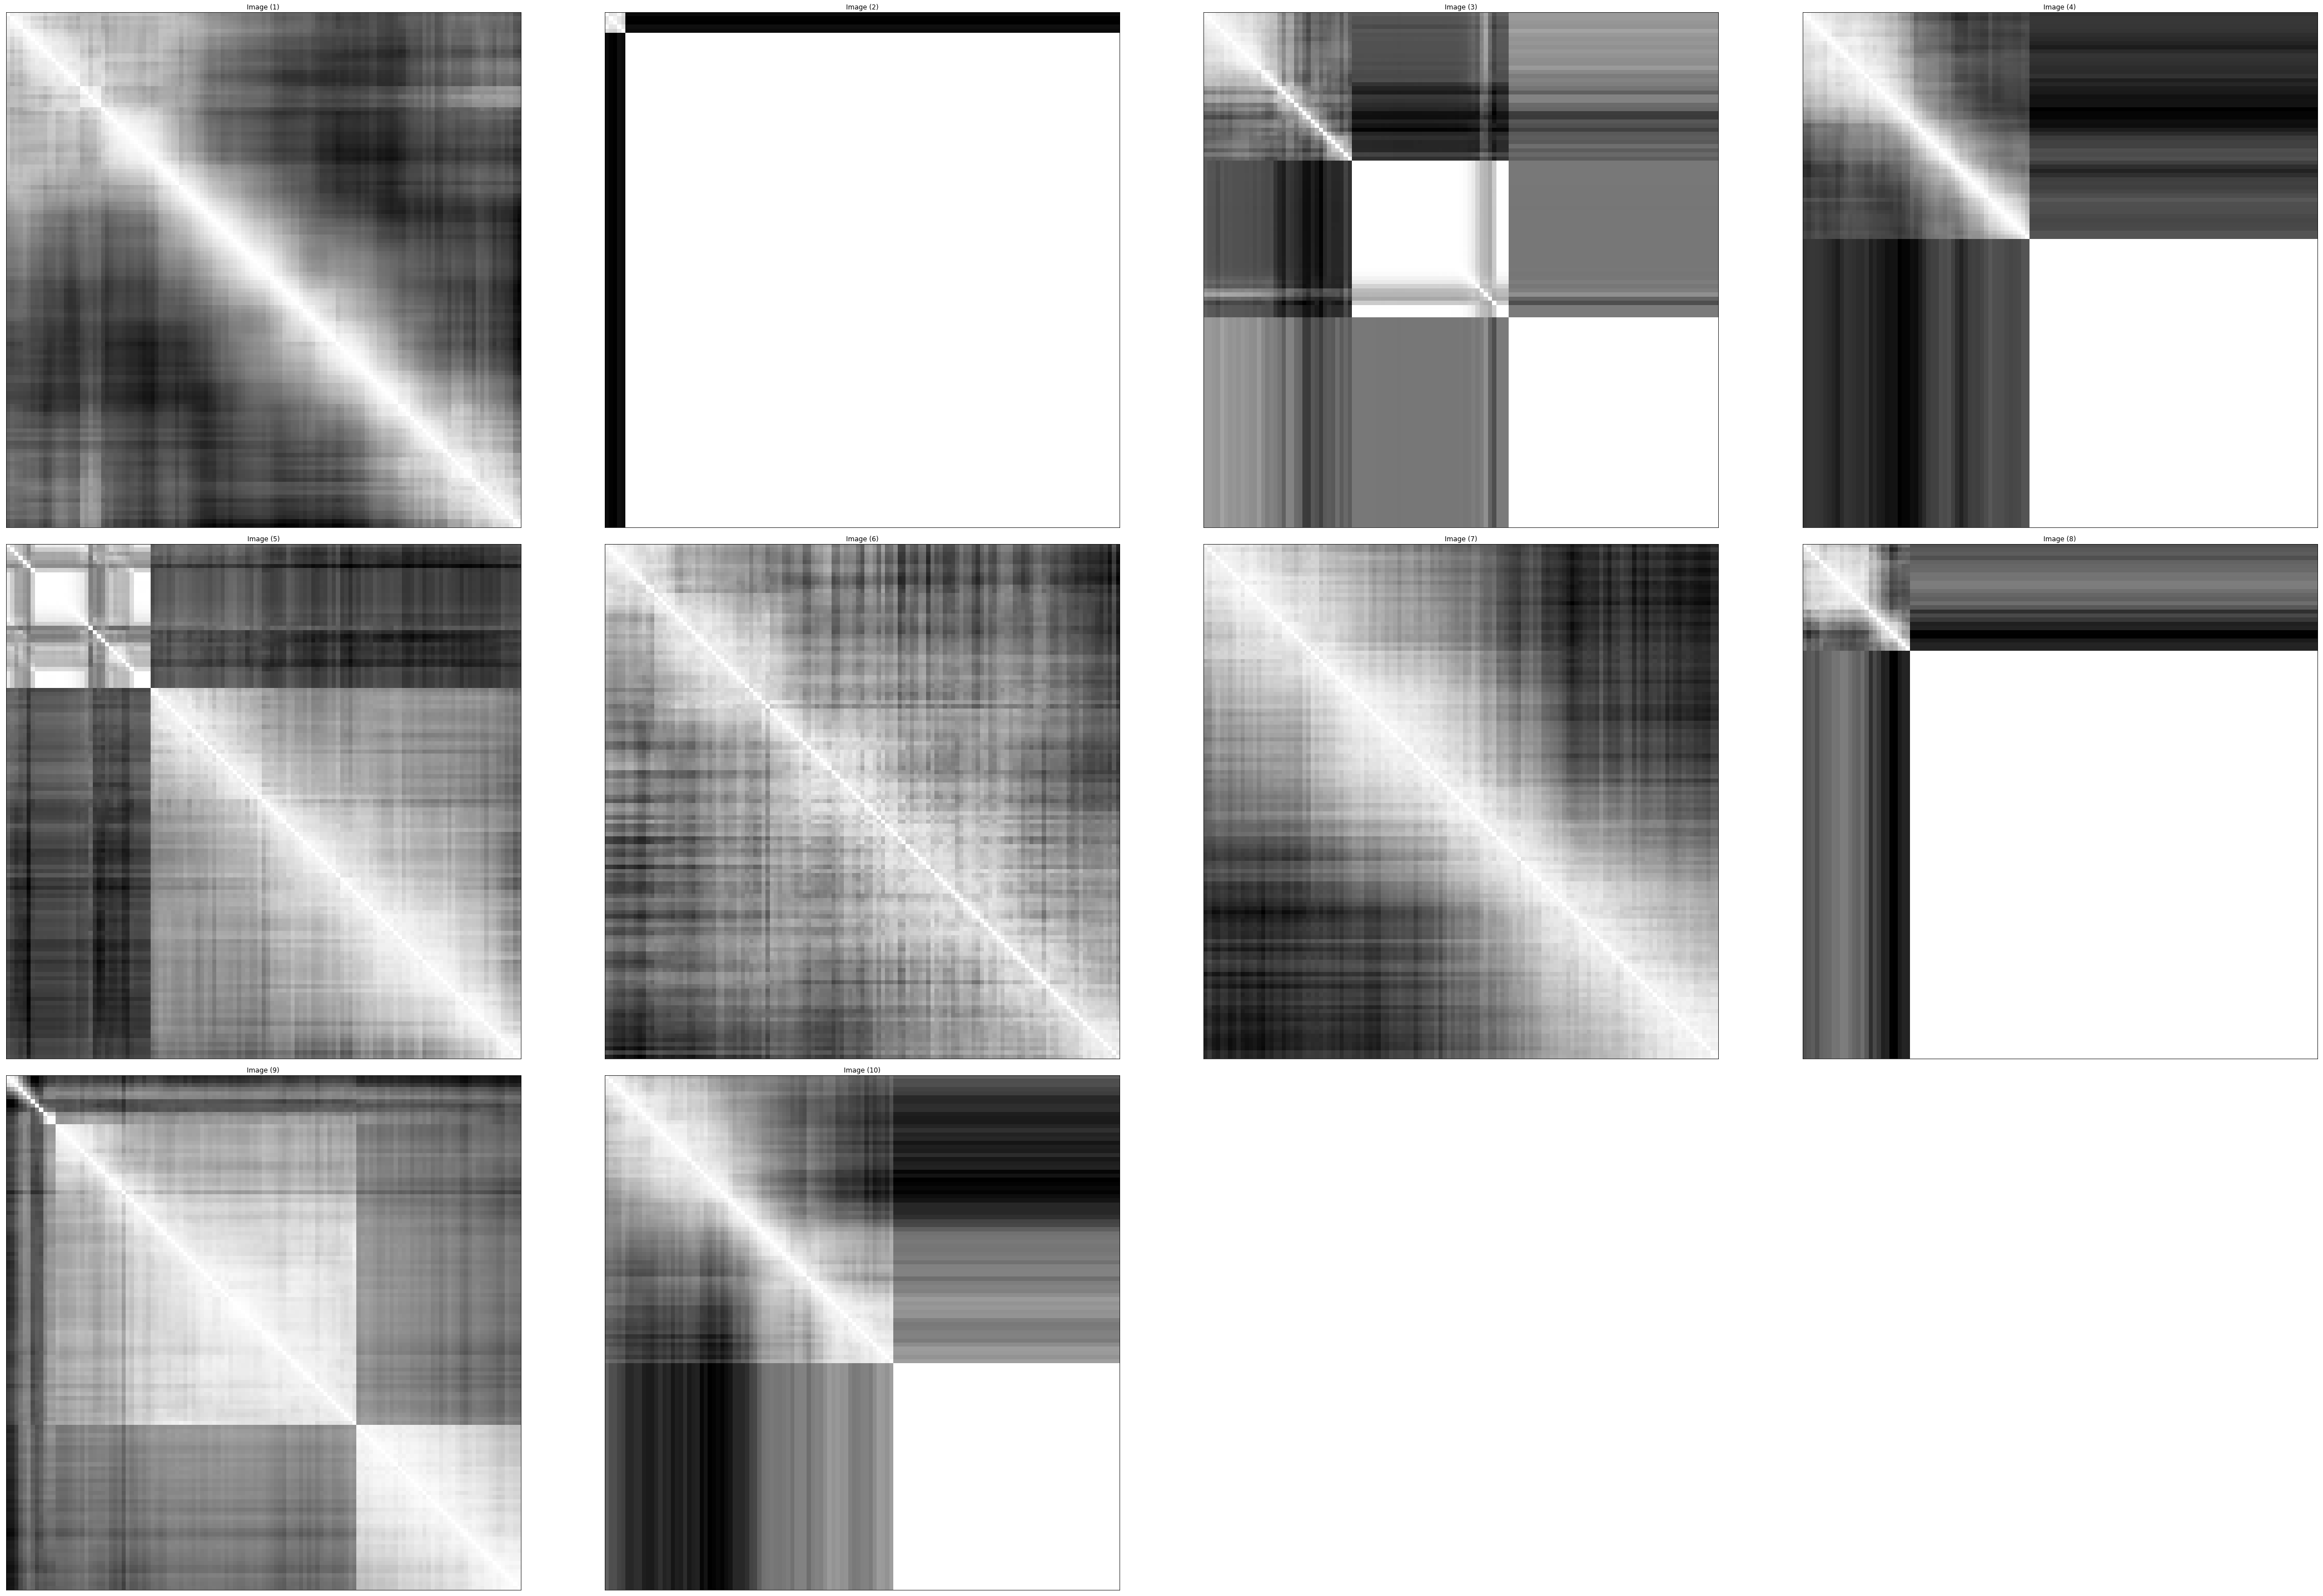

In [52]:
show_images(mats_ncol | select(lambda i: i[1]) | as_list, cols=3)

Collisions

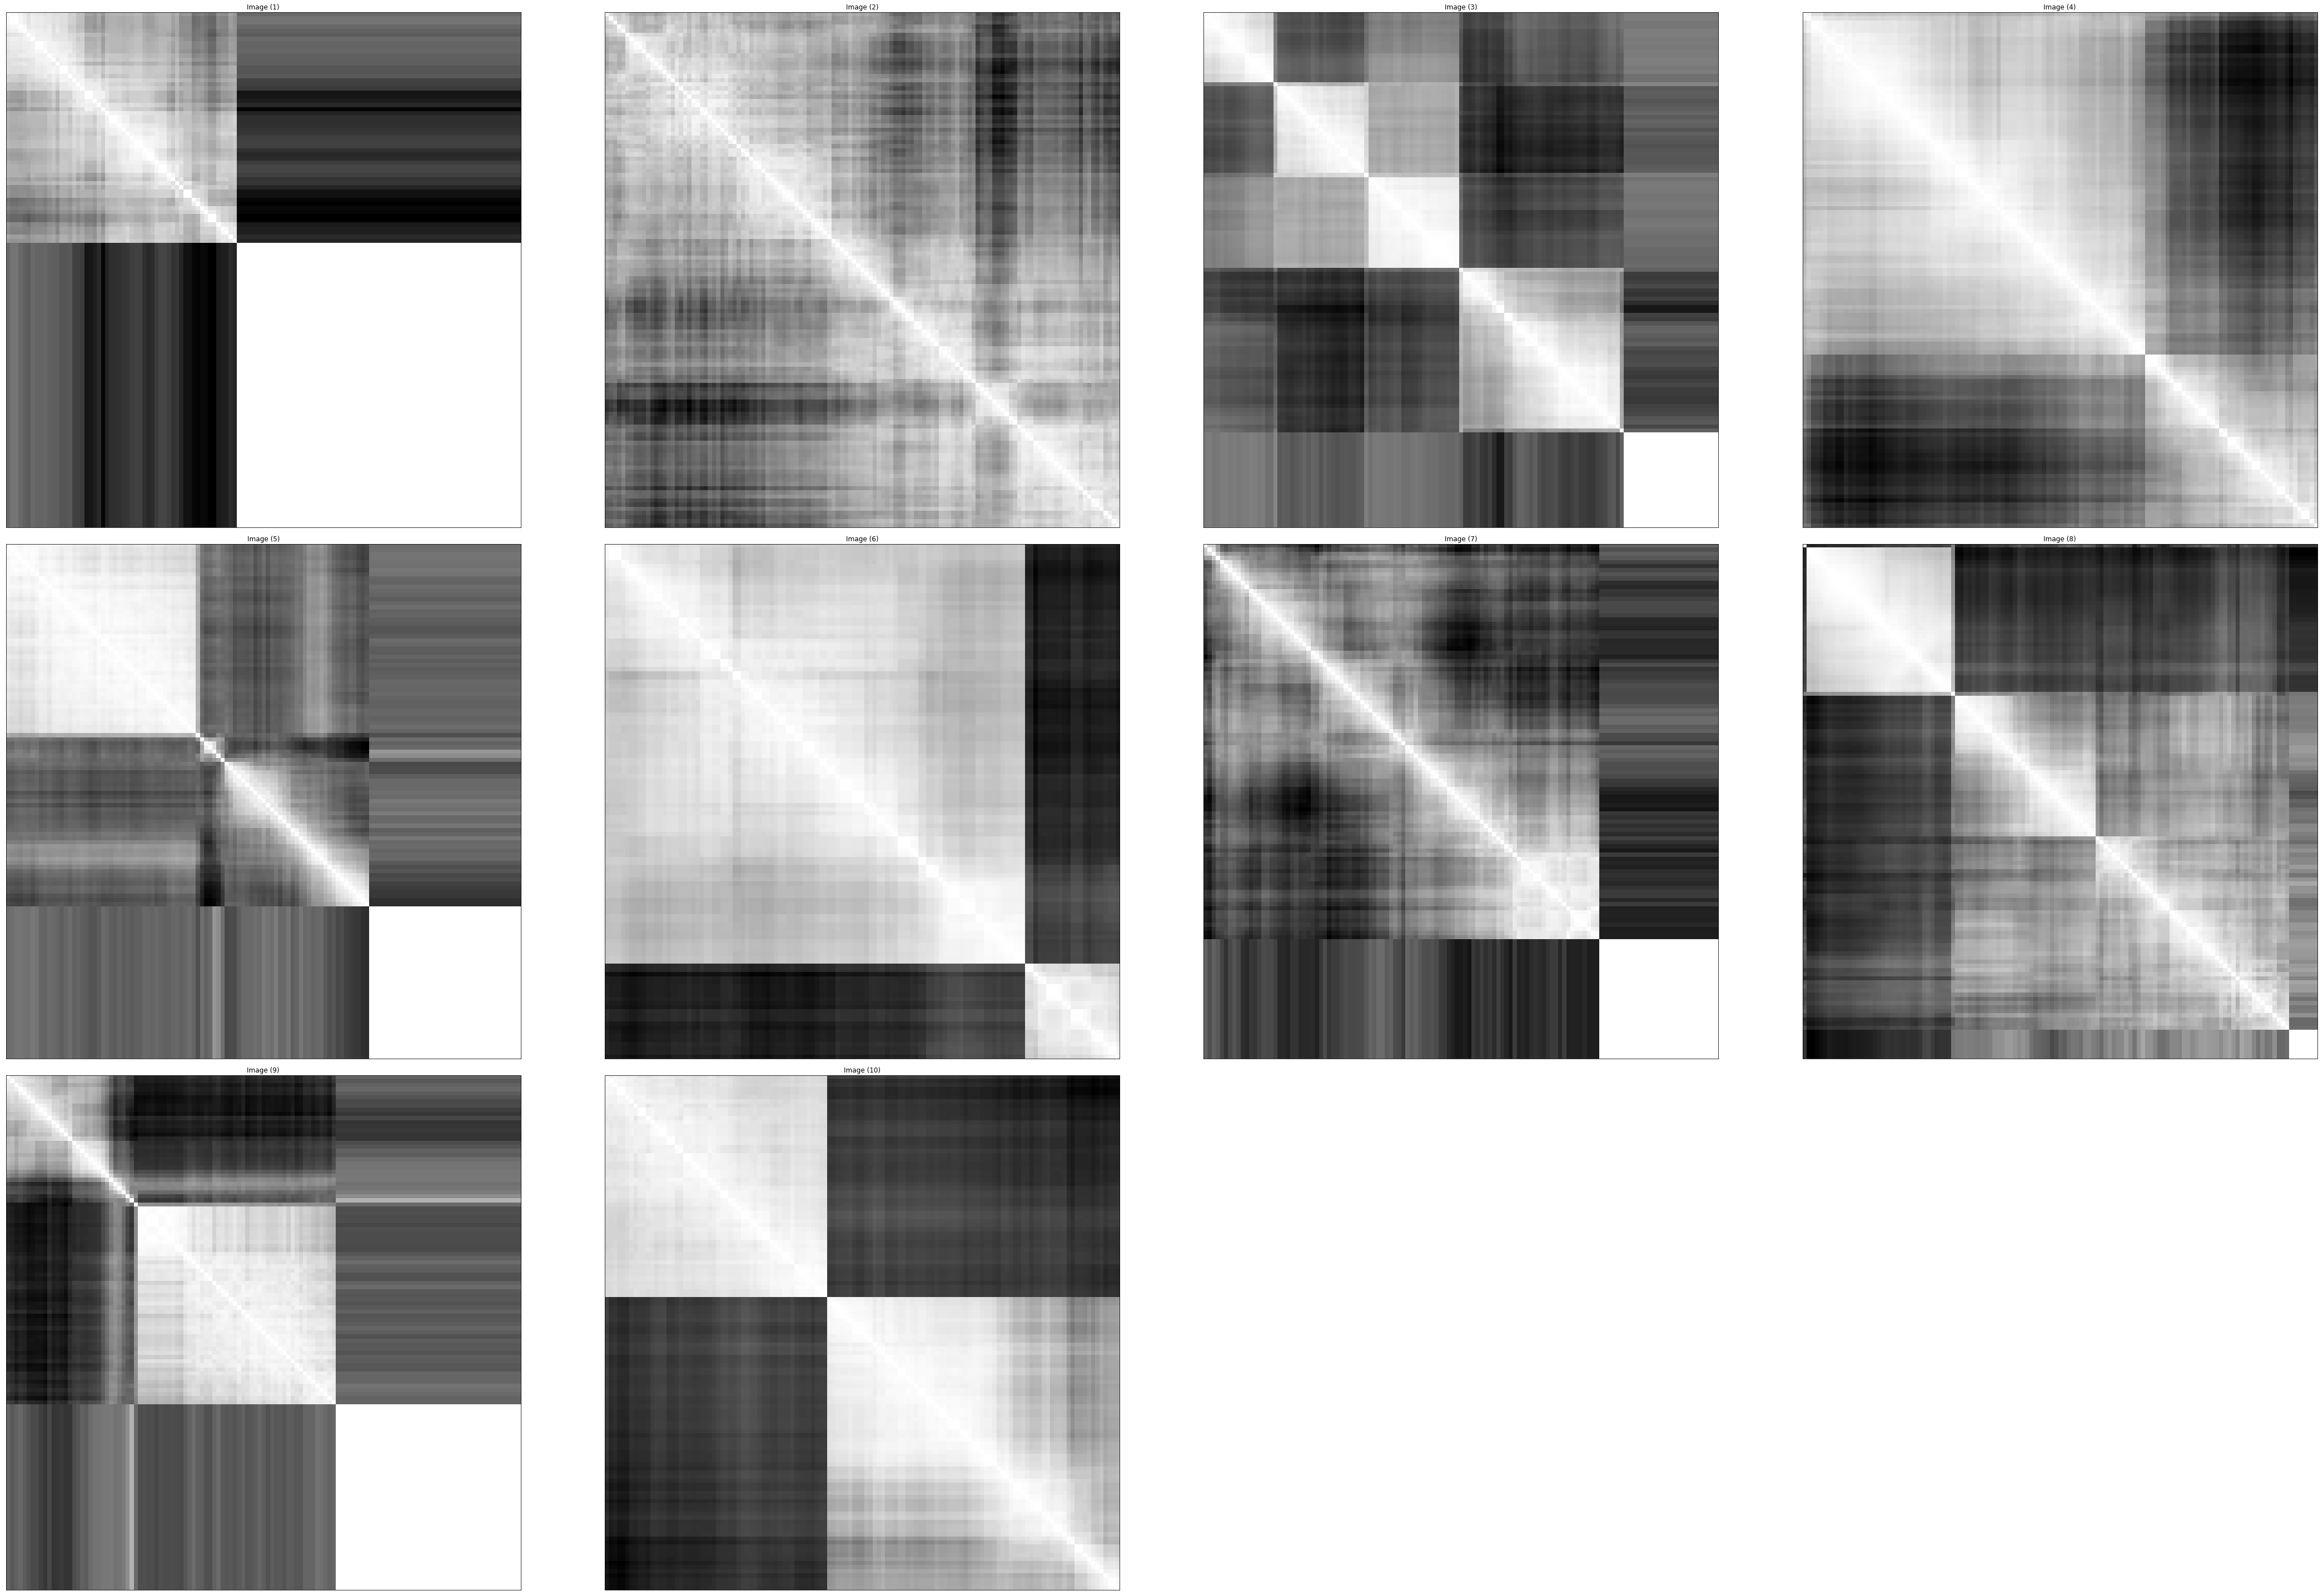

In [53]:
show_images(mats_col | select(lambda i: i[1]) | as_list, cols=3)

Collisions seem to have more regionality i.e. more transients in time

In [81]:
allcols = mats_col | select(lambda i: i[1]) | as_list | as_npy
allncols = mats_ncol | select(lambda i: i[1]) | as_list | as_npy

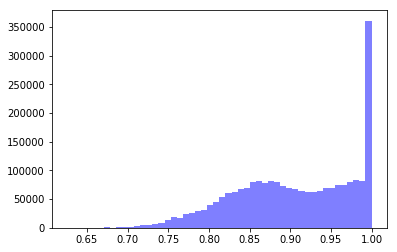

In [82]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
 
num_bins = 50
n, bins, patches = plt.hist(allcols.flatten(), num_bins, facecolor='blue', alpha=0.5)
plt.show()

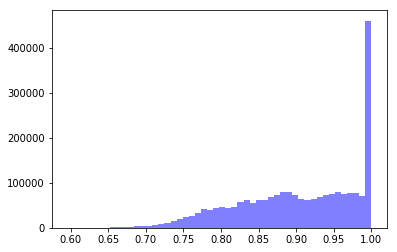

In [83]:

n, bins, patches = plt.hist(allncols.flatten(), num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [87]:
np.histogram( allncols.flatten(), bins=100 )

(array([     2,      2,      6,     14,      8,     44,     48,     60,
           114,    176,    172,    182,    228,    244,    288,    416,
           536,    484,    664,    678,    938,   1184,   1572,   1714,
          1840,   2478,   2204,   2830,   2494,   3564,   3716,   4240,
          4426,   5456,   6968,   8036,  10384,   9760,  11400,  12874,
         11210,  14580,  15986,  18048,  19968,  22304,  20964,  18842,
         23566,  20264,  22624,  23356,  24730,  20130,  22782,  23264,
         29162,  28160,  32256,  30532,  29164,  26904,  30178,  32070,
         32030,  29256,  33636,  33794,  34962,  37586,  40326,  38780,
         39910,  39416,  38444,  35416,  32802,  30270,  31306,  30686,
         31688,  32876,  33284,  34894,  35966,  36024,  36560,  38244,
         38732,  40090,  38886,  37380,  38832,  38978,  38014,  38760,
         38960,  32730,  22114, 438630], dtype=int64),
 array([0.59534401, 0.59939057, 0.60343713, 0.6074837 , 0.61153026,
        0.615

Train a model on the histograms

In [202]:
def histo_feature(vec, bins=100):
    his = np.histogram( np.sum( np.diff(dt, axis=1), axis=0 ), bins=bins )[0]
    return ( vec[0], his / np.max(his) )

def get_histograms(validation_data,bins=100):
    return d.video_stream_with_zeropad(validation_data=validation_data) | get_sim_mat() \
        | select( lambda t: histo_feature(t, bins=bins)  )

@Pipe
def batch_flow_histo(flow, batchsize=10,bins=100):
    while (True):
        batch = np.zeros((batchsize, bins))
        labels = np.zeros((batchsize, 1))
        for i in range(batchsize):
            video = next(flow)
            batch[i] = video[1]
            labels[i] = video[0]
        yield (batch, labels)


In [203]:
# from keras import layers
from keras import models, layers
from keras import regularizers

model = models.Sequential()
model.add(layers.Dense(100, activation='relu', input_shape=(200,)))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_33 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_34 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_35 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_36 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_37 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 101       
Total para

In [204]:
from keras import optimizers
from keras import callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Nadam(lr=0.002),
              metrics=['acc'])

filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

checkpoint =  callbacks.ModelCheckpoint(filepath, 
                          monitor='val_loss', 
                          verbose=0, 
                          save_best_only=False, 
                          save_weights_only=False, 
                          mode='auto', 
                          period=1)

train_batch = get_histograms(validation_data=False, bins=200) | batch_flow_histo(bins=200)
val_batch = get_histograms(validation_data=True, bins=200) | batch_flow_histo(bins=200)

history = model.fit_generator(
      train_batch,
      steps_per_epoch=20, 
      validation_data= val_batch, 
      # has to be false on windows..
      use_multiprocessing=False, 
      validation_steps = 15,
      epochs=10,
      callbacks = [checkpoint])

Epoch 1/10
20/20 [==============================] - 20s 999ms/step - loss: 0.6973 - acc: 0.5200 - val_loss: 0.6940 - val_acc: 0.4867
Epoch 2/10
20/20 [==============================] - 15s 736ms/step - loss: 0.6952 - acc: 0.4700 - val_loss: 0.6935 - val_acc: 0.4600
Epoch 3/10
20/20 [==============================] - 15s 744ms/step - loss: 0.6939 - acc: 0.4600 - val_loss: 0.6930 - val_acc: 0.5333
Epoch 4/10
12/20 [=================>............] - ETA: 3s - loss: 0.6947 - acc: 0.4833

KeyboardInterrupt: 

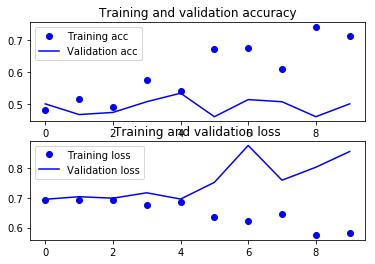

In [175]:
%autoreload

from utils.plotutils import plot_model

plot_model(history)

clever 3d cnn idea, this is getting quite smart arse now but we take windows down the diagonal of the simmat and transform them into 3d cnn tiles

In [364]:

def get3DCnnSimMat(validation_data):
    data = d.video_stream_with_zeropad(validation_data=validation_data) | get_sim_mat() 
    
    for dt in data:
        yield ( dt[0], range(0,125,10) | skip(1) | select( lambda i: dt[1][ i-10:i, i-10:i ] ) | as_npy() )

@Pipe
def batch_flow_3dcnnsimmat(flow, batchsize=10):
    while (True):
        batch = np.zeros((batchsize, 12,10,10,1))
        labels = np.zeros((batchsize, 1))
        for i in range(batchsize):
            video = next(flow)
            batch[i] = video[1].reshape(12,10,10,1)
            labels[i] = video[0]
        yield (batch, labels)
      

In [361]:
# from keras import layers
from keras import models, layers
from keras import regularizers

model = models.Sequential()
model.add(layers.Conv3D(32,(3, 3, 3), activation='relu', input_shape=(12,10,10,1)))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(64,(3, 3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 10, 8, 8, 32)      896       
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 5, 4, 4, 32)       0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 3, 2, 2, 64)       55360     
_________________________________________________________________
flatten_11 (Flatten)         (None, 768)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 100)               76900     
_________________________________________________________________
dense_67 (Dense)             (None, 100)               10100     
__________

In [365]:
from keras import optimizers
from keras import callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Nadam(lr=0.002),
              metrics=['acc'])

filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

checkpoint =  callbacks.ModelCheckpoint(filepath, 
                          monitor='val_loss', 
                          verbose=0, 
                          save_best_only=False, 
                          save_weights_only=False, 
                          mode='auto', 
                          period=1)

train_batch = get3DCnnSimMat(validation_data=False) | batch_flow_3dcnnsimmat()
val_batch = get3DCnnSimMat(validation_data=True) | batch_flow_3dcnnsimmat()

history = model.fit_generator(
      train_batch,
      steps_per_epoch=20, 
      validation_data= val_batch, 
      # has to be false on windows..
      use_multiprocessing=False, 
      validation_steps = 15,
      epochs=10,
      callbacks = [checkpoint])

Epoch 1/10
20/20 [==============================] - 21s 1s/step - loss: 0.7019 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5067
Epoch 2/10
20/20 [==============================] - 15s 747ms/step - loss: 0.6959 - acc: 0.4700 - val_loss: 0.6935 - val_acc: 0.4800
Epoch 3/10
20/20 [==============================] - 15s 752ms/step - loss: 0.6946 - acc: 0.4650 - val_loss: 0.6928 - val_acc: 0.5267
Epoch 4/10
20/20 [==============================] - 15s 756ms/step - loss: 0.6943 - acc: 0.4400 - val_loss: 0.6932 - val_acc: 0.4933
Epoch 5/10
20/20 [==============================] - 15s 764ms/step - loss: 0.6940 - acc: 0.4600 - val_loss: 0.6932 - val_acc: 0.4733
Epoch 6/10
20/20 [==============================] - 15s 755ms/step - loss: 0.6942 - acc: 0.4400 - val_loss: 0.6930 - val_acc: 0.5267
Epoch 7/10
20/20 [==============================] - 15s 750ms/step - loss: 0.6943 - acc: 0.4300 - val_loss: 0.6932 - val_acc: 0.4867
Epoch 8/10
20/20 [==============================] - 15s 759ms/step - los

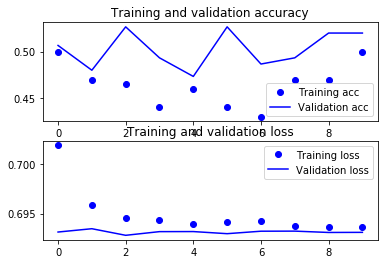

In [366]:
%autoreload

from utils.plotutils import plot_model

plot_model(history)

This is not a good result, seems to suggest that 










































there is no obvious dependency between the scene structure and the target class